In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

Cargar los datos del CSV

In [ ]:
df = pd.read_csv("CO2.csv")

# PARTE 1: ajusta de la tendencia con curve_fit()

Graficar!

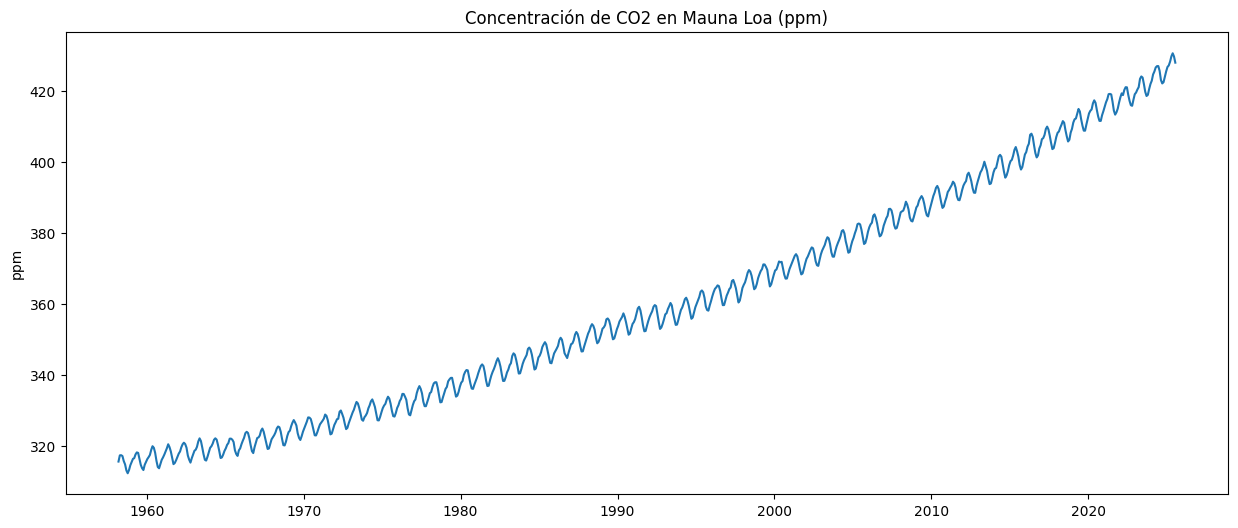

In [ ]:
plt.plot(df["Year"], df["CO2 (ppm)"])
plt.title("Concentración de CO2 en Mauna Loa (ppm)")
plt.ylabel("ppm")
plt.savefig("CO2_Mauna_Loa.png")

Ajuste de una tendencia lineal a los datos

In [ ]:
# Definimos primero un modelo lineal, que tiene dos parámetros
def recta (x, a, b):
    return a*x + b

In [ ]:
# Ajuste
popt, pcov = curve_fit(recta, df["Year"], df["CO2 (ppm)"])
a,b = popt
print("Ajuste: %.5f * x + %.3f" % (a,b))

Ajuste: 1.65434 * x + -2934.962


Graficamos la tendencia calculada junto con los datos

In [ ]:
# Primero hay que evaluar el modelo creado en las fechas de los datos
tendencia = recta(df["Year"], a, b)

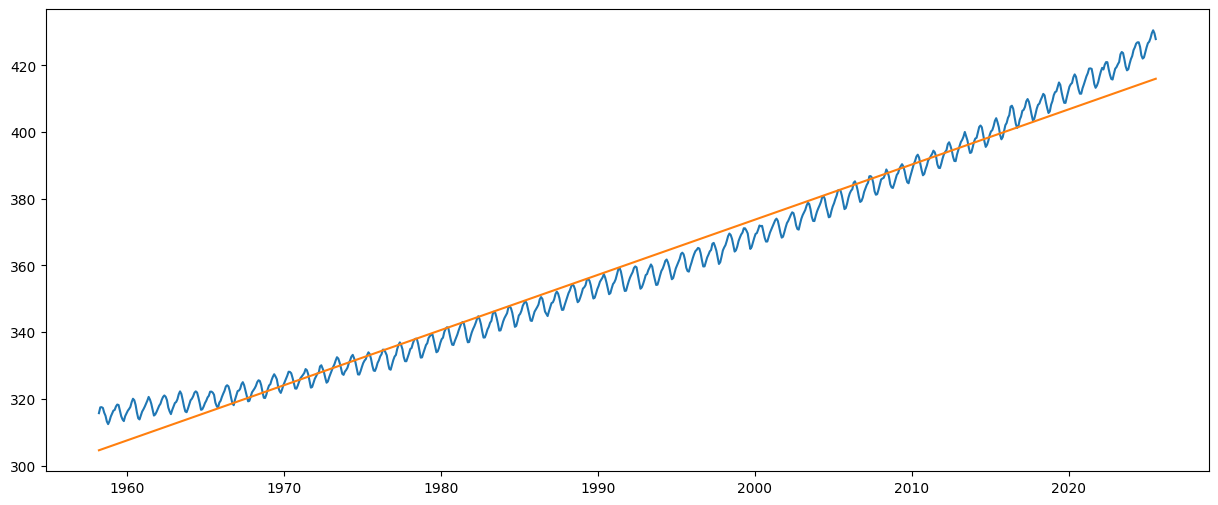

In [ ]:
plt.plot(df["Year"], df["CO2 (ppm)"])
plt.plot(df["Year"], tendencia)

No está tan mal, pero los datos claramente tienen una tendencia más curva

Hagamos un ajuste de una tendencia ***cuadrática***

In [ ]:
# Definimos un modelo cuadrático con 3 parámetros
def parabola (x, a, b, c):
    return a*x**2 + b*x + c

In [ ]:
popt, pcov = curve_fit(parabola, df["Year"], df["CO2 (ppm)"])
a,b,c = popt
print("Ajuste: %.5f * x^2 + %.5f * x + %.2f" % (a,b,c))

Ajuste: 0.01349 * x^2 + -52.08224 * x + 50578.17


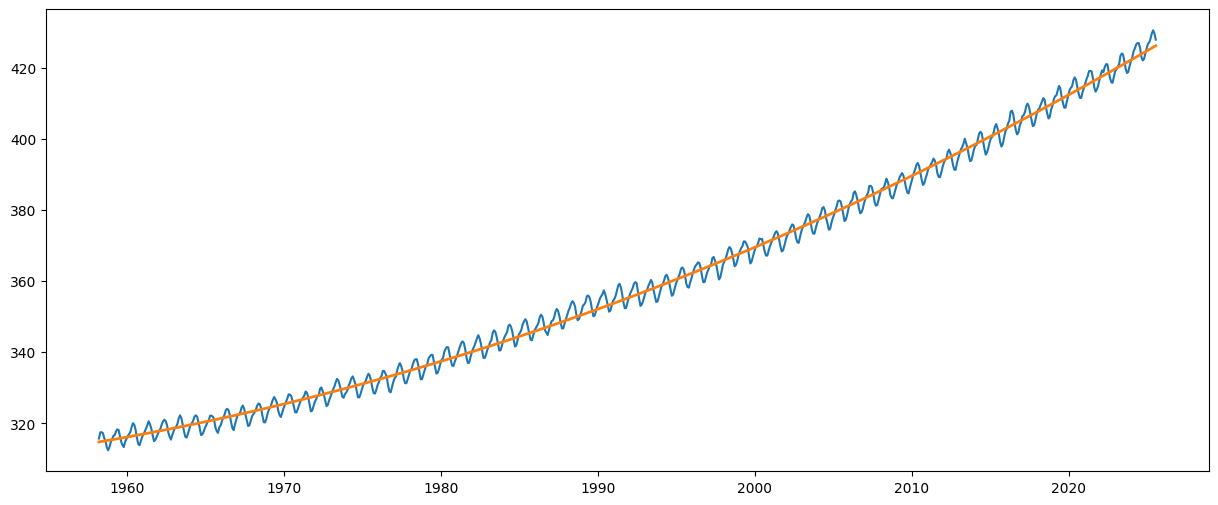

In [ ]:
tendencia2 = parabola(df["Year"], a, b, c)
plt.plot(df["Year"], df["CO2 (ppm)"])
plt.plot(df["Year"], tendencia2, lw=2)

¡Mejor!

# PARTE 2: suavizado de la serie via media móvil

Calcular la media móvil de 12 meses

In [86]:
tiempo = df["Year"]
CO2 = df["CO2 (ppm)"]
media_movil = CO2.rolling(window=12).mean()

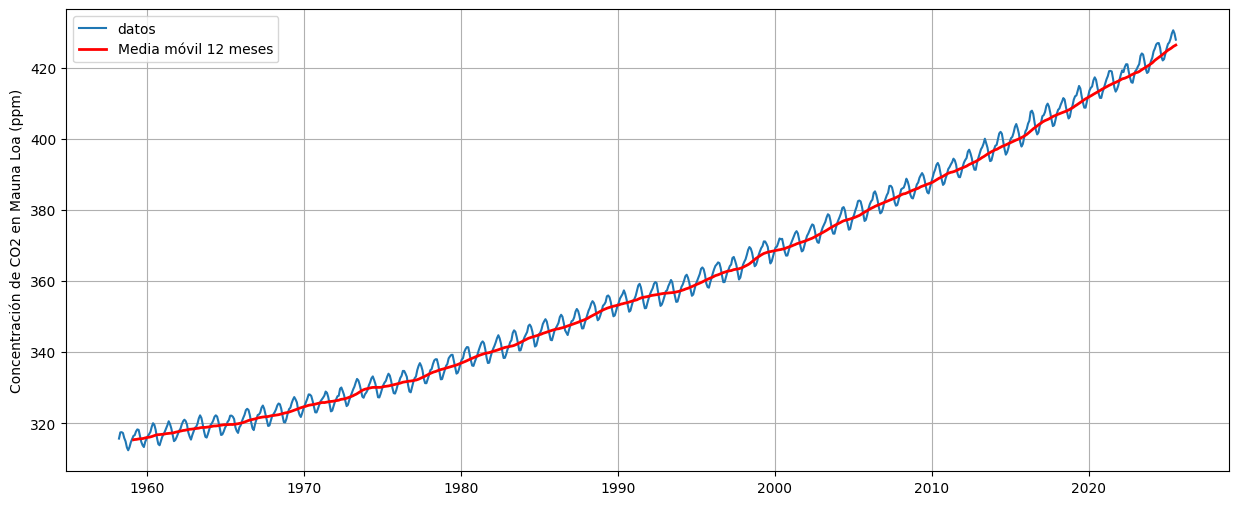

In [41]:
plt.plot(tiempo, CO2, label="datos")
plt.plot(tiempo, media_movil, color="red", lw=2, label="Media móvil 12 meses")
plt.ylabel("Concentración de CO2 en Mauna Loa (ppm)")
plt.legend()
plt.grid()

Si restamos la media móvil (tendencia) a los datos, *des-tendenciamos* la serie de tiempo y nos quedamos con las periodicidades (y el ruido)

In [44]:
CO2_sin_tendencia = CO2 - media_movil

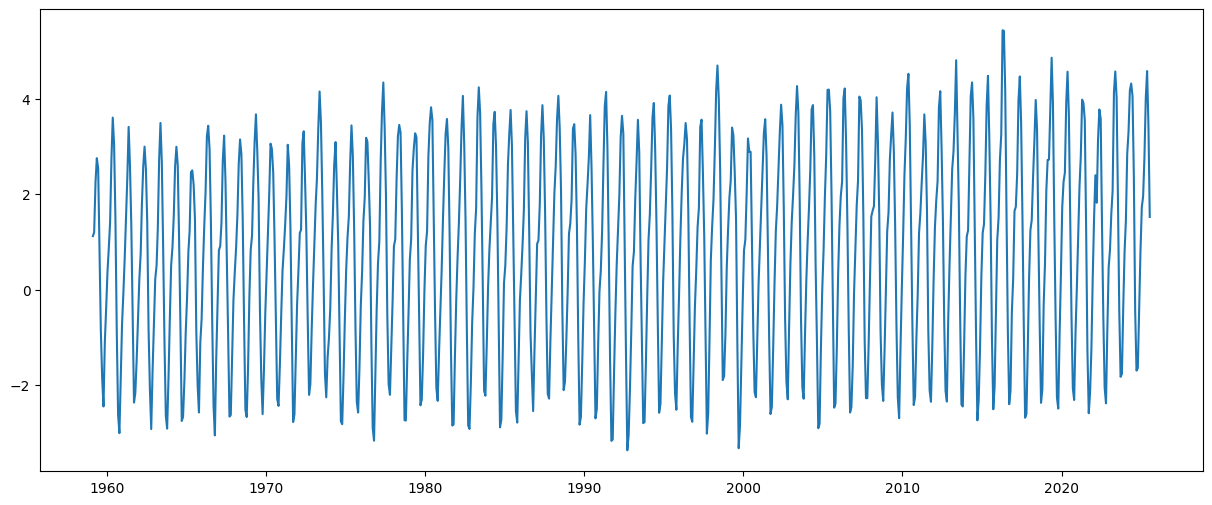

In [45]:
plt.plot(tiempo, CO2_sin_tendencia, label="datos")

Podemos proponer un modelo matemático simple para esta estacionalidad

In [73]:
# Un modelo coseno, con 4 parámetros
def modelo_coseno(x, a, b, c, d):
    return a*np.cos(b*x + c) + d

In [74]:
popt, pcov = curve_fit(modelo_coseno, tiempo, CO2_sin_tendencia)

ValueError: operands could not be broadcast together with shapes (809,) (798,) 

curve_fit no funciona si hay valores inválidos, así que hay que removerlos primero

In [75]:
CO2_sin_tendencia = CO2_sin_tendencia.dropna()
tiempo_limpio = tiempo.iloc[11:]

In [79]:
popt, pcov = curve_fit(modelo_coseno, tiempo_limpio, CO2_sin_tendencia, p0=(3,2*np.pi,0,0))
print(popt)

[ 2.84167137  6.2856832  -6.90579859  0.76505735]


In [82]:
estaciones = modelo_coseno(tiempo_limpio, *popt)

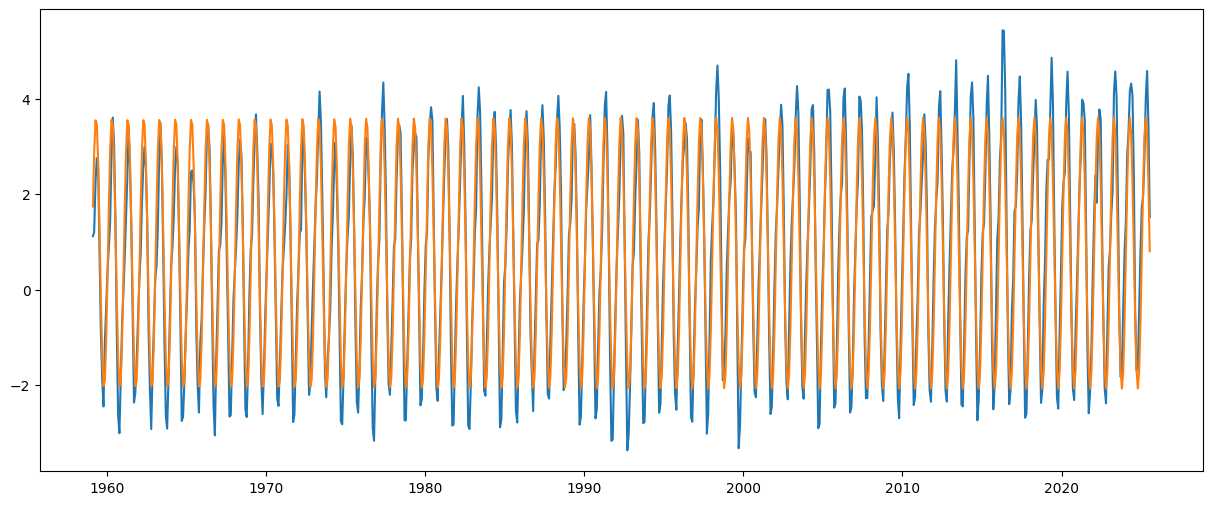

In [83]:
plt.plot(tiempo_limpio, CO2_sin_tendencia)
plt.plot(tiempo_limpio, modelo_estaciones)

Finalmente, podemos construir un modelo compuesto por la suma de la tendencia más las estaciones

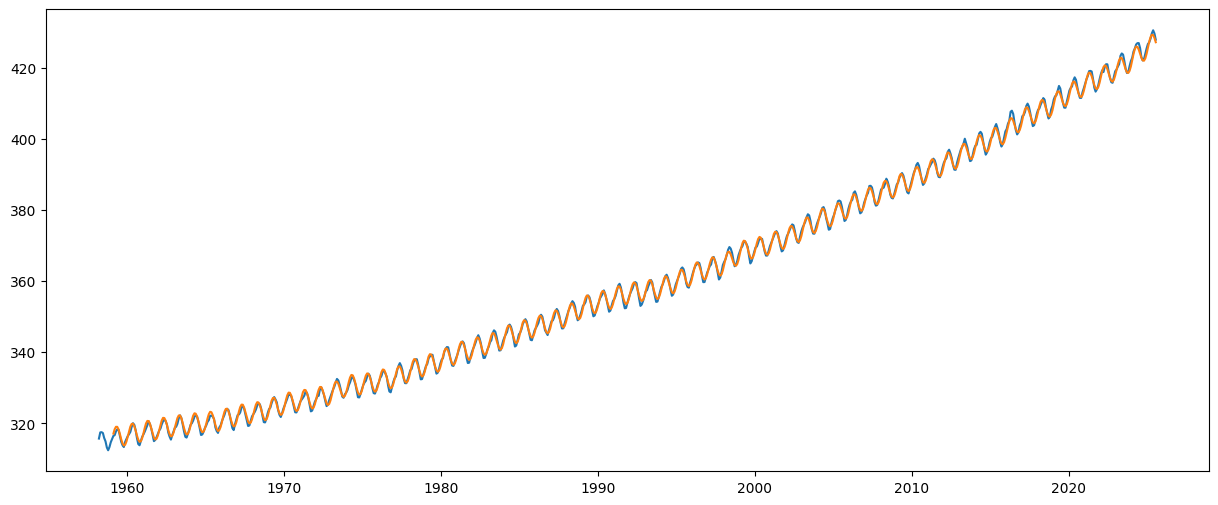

In [88]:
modelo = media_movil + estaciones

plt.plot(tiempo, CO2)
plt.plot(tiempo, modelo)